## <font size='5' color='red'>Contents</font>

* [introduction](#1)

* [Loading required packages](#2)

* [Getting basic Ideas](#3) 

    * [Basic Cleaning]()
    
* [Exploratory Data analysis](#4)

    * [Class distribution]()
    * [Distribution of length of tweets]()
    * [Distribution of number of words in tweets]()
    * [Distribution of target]()
    * [Common Stopwords]()
    * [Common words in tweets w/o stopwords]()
    * [Common bigrams in tweeets]()
    * [WordClouds of tweets]()
    * [Readability index](#5)
    
* [Hints for post-processing](#9)

    * [analyzing jaccard similarity]()



* [Bert-Lstm Model](#7)
    * [Data preparation]()
    * [Model]()
    * [Post processing]()
    * [Making our submission]()

## <font size='4' color='red'>If you find this kernel useful,consider doing an upvote..this will motivate me create more content</font>

## <font size='5' color='green'>Introduction</font><a id='1'></a>

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

Help build your skills in this important area with this broad dataset of tweets. Work on your technique to grab a top spot in this competition. What words in tweets support a positive, negative, or neutral sentiment?
![](https://media.giphy.com/media/xUPGcEOEllmvFAvako/giphy.gif)

## <font size='4' color='green'>Loading Required packages</font><a id='2'></a>


In [ ]:
!pip install textstat

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from collections import defaultdict,Counter
from wordcloud import WordCloud, STOPWORDS
from plotly.subplots import make_subplots
from nltk.tokenize import word_tokenize
import plotly.figure_factory as ff
from nltk.corpus import stopwords
from nltk.corpus import stopwords
import plotly.graph_objects as go
from textblob import TextBlob
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from nltk.util import ngrams
import plotly.offline as py
import plotly.express as px
from statistics import *
from plotly import tools
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import textstat
import string
import json
import nltk
import gc



In [ ]:
py.init_notebook_mode(connected=True)
nltk.download('stopwords')
stop=set(stopwords.words('english'))
plt.style.use('seaborn')


## <font size='4' color='green'>Getting Basic Ideas</font><a id='3'></a>

In [ ]:
train=pd.read_csv("../input/tweet-sentiment-extraction/train.csv")
test=pd.read_csv("../input/tweet-sentiment-extraction/test.csv")
target=train['sentiment']

In [ ]:
print('There are {} rows and {} cols in train set'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} cols in test set'.format(test.shape[0],test.shape[1]))

In [ ]:
train.head(3)

In [ ]:
import re
def basic_cleaning(text):
    text=re.sub(r'https?://www\.\S+\.com','',text)
    text=re.sub(r'[^A-Za-z|\s]','',text)
    return text

def clean(df):
    for col in ['text','selected_text']:
        df[col]=df[col].astype(str).apply(lambda x:basic_cleaning(x))
    return df

colors=['blue','green','red']
sent=train.sentiment.unique()

## <font size='4' color='green'>Exploratory Data Analysis</font><a id='4'></a>

- Let's first take a look at the class distribution of sentiment label

In [ ]:
fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['blue','green','red'],name='train'),row=1,col=1)
x=test.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['blue','green','red'],name='test'),row=1,col=2)

- There is a class imbalance between labels,neutral class dominates over the other class tweets.
- The distributions of labels follows the same trend in train and test.

**But our task is not to predict these labels,but to predict the selected text which can help us figure out the sentiment**

In [ ]:
df=pd.concat([train,test])
df['text']=df['text'].astype(str)
df['seleceted_text']=df['selected_text'].astype(str)

### <font size='3' color='blue'>What's the distribution of length of tweet?</font>

In [ ]:
vals=[]
for i in range(0,3):
    x=df[df['sentiment']==sent[i]]['text'].str.len()
    vals.append(x)

fig = ff.create_distplot(vals, sent,show_hist=False)
fig.update_layout(title="Distribution of number of characters in tweets")
fig.show()

- The number of character in tweets ranges from 1 to 160 (max).
- More tweets contains less than 60 characters.


### <font size='3' color='blue'>What is the distribution of selected text?</font>

In [ ]:
vals=[]
for i in range(0,3):
    x=df[df['sentiment']==sent[i]]['selected_text'].dropna().str.len()
    vals.append(x)

fig = ff.create_distplot(vals, sent)
fig.update_layout(title="Distribution of number of characters in selected text")
fig.show()

- The selected test is of much larger length in neutral sentiment tweets.Why is this ? We wil find out later..
- The distribution of selected texts in positive and negative are almost the same.

### <font size='3' color='blue'>What is the distribution of Number of words in a tweet?</font>

In [ ]:

sent=df.sentiment.unique()
fig,ax= plt.subplots(1,3,figsize=(12,6))
for i in range(0,3):
    df[df['sentiment']==sent[i]]['text'].str.split().str.len().hist(ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i])
fig.suptitle("Distribution of number of No: Words in Tweets", fontsize=14)

- The number of words in tweets ranges from 1 to 30,5-10 being the most common choice.

### <font size='3' color='blue'>What is distribution of number of words in selected text?</font>

In [ ]:

sent=train.sentiment.unique()
fig,ax= plt.subplots(1,3,figsize=(12,6))
for i in range(0,3):
    train[train['sentiment']==sent[i]]['selected_text'].str.split().str.len().hist(ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i])
fig.suptitle("Distribution of number of No: Words in Selected text", fontsize=14)

Yes,this  follows the same trend as of number of characters.

### <font size='3' color='blue'>Which are the most common stopwords?</font>

In [ ]:
def preprocess_news(df,stop=stop,n=1,col='text'):
    '''Function to preprocess and create corpus'''
    new_corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for text in df[col]:
        words=[w for w in word_tokenize(text) if (w not in stop)]
       
        words=[lem.lemmatize(w) for w in words if(len(w)>n)]
     
        new_corpus.append(words)
        
    new_corpus=[word for l in new_corpus for word in l]
    return new_corpus


In [ ]:

fig,ax=plt.subplots(1,3,figsize=(15,7))
for i in range(3):
    new=df[df['sentiment']==sent[i]]
    corpus_train=preprocess_news(new,{})
    
    dic=defaultdict(int)
    for word in corpus_train:
        if word  in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    ax[i].bar(x,y,color=colors[i])
    ax[i].set_title(sent[i],color=colors[i])

fig.suptitle("Common stopwords in different sentiments")

1. `the` dominated in the list of common stopwords,followed by `and` and '`you`

### <font size='3' color='blue'>Distribution of no: punctuations in tweets</font>

In [ ]:
df['punc']=df['text'].apply(lambda x : [c for c in x if c in string.punctuation])
fig,ax=plt.subplots(1,3,figsize=(10,6))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['punc'].map(lambda x: len(x))
    sns.distplot(new,color=colors[i],ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i])
    
fig.suptitle("Number of Punctuations in tweets") 

- All the distributions are left skewed.
- There happens to be more punctuations in positive tweets.

### <font size='3' color='blue'>Number of unique words in tweets</font>

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(12,7))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['text'].map(lambda x: len(set(x.split())))
    sns.distplot(new.values,ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i])
fig.suptitle("Distribution of number of unique words")

hmm..the distribution seems to be quite similar,let us check for selected text

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(12,7))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['selected_text'].astype(str).map(lambda x: len(set(x.split())))
    sns.distplot(new.values,ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i])
fig.suptitle("Distribution of number of unique words")

- For negative and positive tweets this distributions is similar,this should be because of selected keywords from tweets.
- In case of neutral tweets it is spread and there aren't a specefic keyword to select.
- This may cause neutral class to be difficult to predict.

### <font size='3' color='blue'>Common punctuations in tweets</font>

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,10))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['punc']
    punc=[p for pun in new.values for p in pun]
    counter=Counter(punc).most_common(10)
    x,y=zip(*counter)
    ax[i].bar(x,y,color=colors[i])
    ax[i].set_title(sent[i],color=colors[i])
    
fig.suptitle("Punctuations in tweets")   
    
    

## <font size='4' color='blue'>Which are the most common words?</font> 

In [ ]:
df=clean(df)

In [ ]:

fig,ax=plt.subplots(1,3,figsize=(20,12))
for i in range(3):
    new=df[df['sentiment']==sent[i]]
    corpus_train=preprocess_news(new,n=3)
    counter=Counter(corpus_train)
    most=counter.most_common()
    x=[]
    y=[]
    for word,count in most[:20]:
        if (word not in stop) :
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x,ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i],color=colors[i])
fig.suptitle("Common words in tweet text")

- It is evident that there are more positive words like `good`,`thanks` etc on positive tweets.
- It can be observed that there are a lot of negative words in negative tweets.

## <font color='blue' size='4'>Which are the most common words in selected text?</font>

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,12))
for i in range(3):
    new=df[df['sentiment']==sent[i]]   
    corpus=preprocess_news(new,n=3,col='selected_text')
    counter=Counter(corpus)
    most=counter.most_common()
    x=[]
    y=[]
    for word,count in most[:20]:
        if (word not in stop) :
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x,ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i],color=colors[i])
fig.suptitle("Common words in selected text")

- The above trend repreats here ,here it is more evident and clear.
- Let's dig bit further for positive ane negetive words...


### <font size='3' color='blue'>Check for bigrams in selected text</font>

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n),stop_words=stop).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(15,10))
for i in range(2):
    new=df[df['sentiment']==sent[i+1]]['selected_text']
    top_n_bigrams=get_top_ngram(new,2)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x,ax=ax[i],color=colors[i+1])
    ax[i].set_title(sent[i+1])
    
fig.suptitle("Common bigrams in selected text")

- Well,you can see the difference.
- `'positve` tweets are filled with positive words like `great day`,'`happy day` etc.
- `negative` tweets have bigrams like `im sorry`, and many words starting with `dont`.

### <font size='3' color='blue'>WordCloud for tweets</font>

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None,ax=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1 
        )
    
    wordcloud=wordcloud.generate(str(data))
    ax.imshow(wordcloud,interpolation='nearest')
    ax.axis('off')
    #plt.show()

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,12))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['text']
    show_wordcloud(new,ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i])

### <font size='3' color='blue'>Wordcloud for selected text</font>

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,12))
for i in range(3):
    new=df[df['sentiment']==sent[i]]['selected_text'].dropna()
    show_wordcloud(new,ax=ax[i])
    ax[i].set_title(sent[i],color=colors[i])
    

Let's do the same for selected_text and see the distribution

## <font color='green' size='4'>Readability features</font><a id='5'></a>

Readability is the ease with which a reader can understand a written text. In natural language processing, the readability of text depends on its content. It focuses on the words we choose, and how we put them into sentences and paragraphs for the readers to comprehend.
9.1 The Flesch Reading Ease formula

   - In the Flesch reading-ease test, higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read. The formula for the Flesch reading-ease score (FRES) test is 
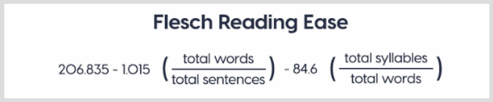   
   
   
   
  -  90-100 - Very Easy
  -  80-89 - Easy
  -  70-79 - Fairly Easy
  -  60-69 - Standard
  -  50-59 - Fairly Difficult
  -  30-49 - Difficult
  -  0-29 - Very Confusing


In [ ]:
#utility functions:
def plot_readability(a,b,c,title,bins=0.4,colors=colors):
    trace1 = ff.create_distplot([a,b,c],sent, bin_size=bins, colors=colors, show_rug=False)
    trace1['layout'].update(title=title)
    py.iplot(trace1, filename='Distplot')
    table_data= [["Statistical Measures","neu",'pos','neg'],
                ["Mean",mean(a),mean(b),mean(c)],
                ["Standard Deviation",pstdev(a),pstdev(b),pstdev(c)],
                ["Variance",pvariance(a),pvariance(b),pvariance(c)],
                ["Median",median(a),median(b),median(c)],
                ["Maximum value",max(a),max(b),max(c)],
                ["Minimum value",min(a),min(b),min(c)]]
    trace2 = ff.create_table(table_data)
    py.iplot(trace2, filename='Table')


In [ ]:
tqdm.pandas()
fre_neu = np.array(df["text"][df["sentiment"] == sent[0]].progress_apply(textstat.flesch_reading_ease))
fre_pos = np.array(df["text"][df["sentiment"] == sent[1]].progress_apply(textstat.flesch_reading_ease))
fre_neg = np.array(df["text"][df["sentiment"] == sent[2]].progress_apply(textstat.flesch_reading_ease))

plot_readability(fre_neu,fre_pos,fre_neg,"Flesch Reading Ease",20)

- Mean score of tweets is ~70,so it is considered as fairly easy to read.

## <font size='4' color='red'>Hints for post processing</font><a id='9'></a>

In [ ]:
def jaccard(str1, str2): 
    a = set(str(str1).lower().split()) 
    b = set(str(str2).lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [ ]:
def plot_jaccard(sentiment,ax):
    jacc=[]
    text=train[train['sentiment']==sentiment].dropna()['text'].values.tolist()
    selected=train[train['sentiment']==sentiment].dropna()['selected_text'].values.tolist()
    for i,k in zip(text,selected):
        jacc.append(jaccard(i,k))
    ax.hist(jacc,bins=10,color='blue',alpha=0.4)
    ax.set_title(sentiment)
    

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
plot_jaccard('positive',ax=ax1)
plot_jaccard('negative',ax2)
plot_jaccard('neutral',ax3)
fig.suptitle('jaccard similarity of text and selected text')

- here we can easily observe that the jaccard similarity of most of samples with negative sentiment is close to 1,which means that most of the text is in selected text.
- Also there are some examples in positive and negative tweets with similarity of 1 (entire text).We will investigate them too.

In [ ]:
train['jaccard']=train.apply(lambda x : jaccard(x.text,x.selected_text),axis=1)
positive=train[(train['sentiment']=='positive') & (train['jaccard']>0.9)]

In [ ]:
positive.head()

- Are these examples due to some manual errors? There seems to be positive keywords in them like "love","cute","welcome" etc..
- let's examine if this has anything to do with text length

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
x=train[train['sentiment']=='positive']['text'].str.len()
y=train[(train['sentiment']=='positive')]['jaccard'].values.tolist()
ax1.scatter(x,y,color='green',alpha=.4)
ax1.set_xlabel('text length')
ax1.set_ylabel('jaccard similarity with selected text')
ax1.set_title("text length vs jaccard similarity")
x=train[train['sentiment']=='positive']['text'].apply(lambda x : len(x.split()))
ax2.scatter(x,y,color='green',alpha=.4)
ax2.set_xlabel('text length')
ax2.set_ylabel('jaccard similarity with selected text')
ax2.set_title("no: of words vs jaccard similarity")

Couldn't find any evidence or relation between them in positive tweets.Let's check for negative tweets

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
x=train[train['sentiment']=='negative']['text'].str.len()
y=train[(train['sentiment']=='negative')]['jaccard'].values.tolist()
ax1.scatter(x,y,color='red',alpha=.4)
ax1.set_xlabel('text length')
ax1.set_ylabel('jaccard similarity with selected text')
ax1.set_title("text length vs jaccard similarity")
x=train[train['sentiment']=='negative']['text'].apply(lambda x : len(x.split()))
ax2.scatter(x,y,color='red',alpha=.4)
ax2.set_xlabel('text length')
ax2.set_ylabel('jaccard similarity with selected text')
ax2.set_title("no: of words vs jaccard similarity")

Same here !
I think in this situation we should check the distribution of sentiment polarity of selected text.See if it actually matches with the label or if there are any outliers.

In [ ]:
def get_sent(text):
    testimonial = TextBlob(str(text))
    return testimonial.sentiment.polarity

plt.figure(figsize=(10,7))
train['polarity']=train['selected_text'].apply(lambda x : get_sent(x))
sns.boxplot(x='sentiment', y='polarity', data=train)
plt.gca().set_title('Sentiment vs Polarity of selected text')
plt.show()



Wow,the results look pretty satisfactory,but there are outliers especially in the negative tweets.

let's check the correlation between the number of words in tweet and selected text


In [ ]:
import scipy
corr=[]
for i in sent:
    text_pos=train[train['sentiment']==i]['text'].astype(str).map(lambda x : len(x.split()))
    sel_pos=train[train['sentiment']==i]['selected_text'].astype(str).map(lambda x : len(x.split()))
    corr.append(scipy.stats.pearsonr(text_pos,sel_pos)[0])
plt.bar(sent,corr,color='blue',alpha=.7)
plt.gca().set_title("pearson corr between no: words in text and selected text")
plt.gca().set_ylabel("correlation")

## <font size='4' color='red'>Tensorflow roberta model</font>

In [ ]:
from transformers import *
import tensorflow as tf
import tokenizers

- Many many thanks to one of the most wonderful kaggler @chrisdeotte for his [kernel](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705/data).Take a second to upvote his work.
- I have done an inference with this by training 6 epochs and 5 folds.



In [ ]:
MAXLEN=128
PATH = '../input/tf-roberta/'
tokenizer=tokenizers.ByteLevelBPETokenizer(vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True)

sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')



In [ ]:
ct=train.shape[0]
input_ids=np.ones((ct,MAXLEN),dtype='int32')
attention_mask=np.zeros((ct,MAXLEN),dtype='int32')
token_type_ids=np.zeros((ct,MAXLEN),dtype='int32')
start_tokens=np.zeros((ct,MAXLEN),dtype='int32')
end_tokens=np.zeros((ct,MAXLEN),dtype='int32')


for k in tqdm(range(ct)):
    
    text1=" "+" ".join(train.loc[k,"text"].split())
    text2=" ".join(train.loc[k,"selected_text"].split())
    idx=text1.find(text2)
    chars=np.zeros(len(text1))
    chars[idx:idx+len(text2)]=1
    if (text1[idx-1]==" "):
        chars[idx-1]=1
    enc=tokenizer.encode(text1)
    
    offsets=enc.offsets
    
    toks=[]
    for i,(a,b) in enumerate(offsets):
        sm=np.sum(chars[a:b])
        if sm > 0:
            toks.append(i)
            
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1
    
    


In [ ]:
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAXLEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAXLEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAXLEN),dtype='int32')

for k in tqdm(range(test.shape[0])):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1



In [ ]:
def build_model():
    ids = tf.keras.layers.Input((MAXLEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAXLEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAXLEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

In [ ]:
model=build_model()

In [ ]:
import os
models=os.listdir("../input/tfroberta5fold6epochs")
model_file_path="../input/tfroberta5fold6epochs/"

In [ ]:
start_token=np.zeros((ct,MAXLEN),dtype='float64')
end_token=np.zeros((ct,MAXLEN),dtype='float64')

for model_path in models:
    model.load_weights(model_file_path+model_path)
    pred=model.predict([input_ids_t,attention_mask_t,token_type_ids_t])
    
    start_token+=pred[0]/len(models)
    end_token+=pred[1]/len(models)



In [ ]:
start_token=np.argmax(start_token,axis=1)
end_token=np.argmax(end_token,axis=1)
selected_text=[]
for k in range(ct):
    
    a=start_token[k]
    b=end_token[k]
    if a<b:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        selected_text.append(tokenizer.decode(enc.ids[a-1:b]))
    else:
        if test.loc[k,'sentiment']=="neutral":
            selected_text.append(test.loc[k,'text'])
        else:
            text1 = " "+" ".join(test.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            selected_text.append(tokenizer.decode(enc.ids[b-1:a]))
            
    

In [ ]:
test['selected_text']=selected_text
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.head(5)

In [ ]:
del model
gc.collect()

## <font size='4' color='blue'>BERT Embeddings with LSTM Model</font><a id='5'></a>

In [ ]:
cols=['textID','text','sentiment','selected_text']
train_df=train[cols].copy()
del train
test_df=test.copy()
del test
gc.collect()

In this section I am trying to build a multi-input model using BERT embedding for predicting the target keyphrases.
I will explain my approach step by step,this is a naive approach and will be improved later.

In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import concatenate
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import gc
import os

In [ ]:
train_df=pd.read_csv("../input/tweet-sentiment-extraction/train.csv")
test_df=pd.read_csv("../input/tweet-sentiment-extraction/test.csv")

### Data preparation

- Below function is from this [kernel](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras) by @xhlulu,this is used to encode the sentences easily and quickly using distilbert tokenizer.

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=128):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

- We load the Distilbert pretained tokenizer (uncased) and save it to directory.
- Reload and use BertWordPieceTokenizer.
- An implementation of a tokenizer consists of the following pipeline of processes, each applying different transformations to the textual information:
![](https://miro.medium.com/max/1400/1*7uy9X3eE1rVmqV08yKrDgg.png)

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')  ## change it to commit

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

- Now the comment text is prepared and encoded using this tokenizer easily.
- We here set the maxlen=128,(limit)

In [ ]:
x_train = fast_encode(train_df.text.astype(str), fast_tokenizer, maxlen=128)
x_test = fast_encode(test_df.text.astype(str),fast_tokenizer,maxlen=128)

- Now we load the pretrained bert ('uncased') transformer layer.
- This is used for creating the representations and training our corpus.

In [ ]:
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

This code is lifted from [kernel](https://www.kaggle.com/gskdhiman/bert-baseline-starter-kernel#Training).
- In this section we create the representaion for the selected text from tweet text.
- The representation is created such that the positions of tokens which is selcted from text is represented with 1 and others with 0.
- for example,consider the tweet `" I have a cute dog"` and selected text `"cute dog"`
- This produces the ouput as ` [0,0,0,1,1]`

In [ ]:
def create_targets(df):
    df['t_text'] = df['text'].apply(lambda x: tokenizer.tokenize(str(x)))
    df['t_selected_text'] = df['selected_text'].apply(lambda x: tokenizer.tokenize(str(x)))
    def func(row):
        x,y = row['t_text'],row['t_selected_text'][:]
        for offset in range(len(x)):
            d = dict(zip(x[offset:],y))
            #when k = v that means we found the offset
            check = [k==v for k,v in d.items()]
            if all(check)== True:
                break 
        return [0]*offset + [1]*len(y) + [0]* (len(x)-offset-len(y))
    df['targets'] = df.apply(func,axis=1)
    return df

train_df = create_targets(train_df)

print('MAX_SEQ_LENGTH_TEXT', max(train_df['t_text'].apply(len)))
print('MAX_TARGET_LENGTH',max(train_df['targets'].apply(len)))
MAX_TARGET_LEN=108

- Now we need to make each output of the same length to feed it to the neural network.
- For that we find the maxlength of the target and pad all other target to this length.

In [ ]:
train_df['targets'] = train_df['targets'].apply(lambda x :x + [0] * (MAX_TARGET_LEN-len(x)))
targets=np.asarray(train_df['targets'].values.tolist())


- We need to use the sentiment as a feature,for this encode it using LabelEncode.

In [ ]:
lb=LabelEncoder()
sent_train=lb.fit_transform(train_df['sentiment'])
sent_test=lb.fit_transform(test_df['sentiment'])

## Model

- This is a multi-input model (comment+sentiment label).
- I have made a simple LSTM model
- concatenated both the inputs 

In [ ]:
def new_model(transformer_layer):
    
    inp = Input(shape=(128, ))
    inp2= Input(shape=(1,))
    
    embedding_matrix=transformer_layer.weights[0].numpy()

    x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)

    x = CuDNNLSTM(150, return_sequences=True,name='lstm_layer',)(x)
    x = CuDNNLSTM(100, return_sequences=False,name='lstm_layer-2',)(x)
    
    y =Dense(10,activation='relu')(inp2)
    x= concatenate([x,y])
    
    x = Dense(MAX_TARGET_LEN,activation='sigmoid')(x)

    model = Model(inputs=[inp,inp2], outputs=x)

    model.compile(loss='binary_crossentropy',
                      optimizer='adam')


    #prinnt(model.summary())
    
    return model

- Fitting the model 

In [ ]:

model=new_model(transformer_layer)
history=model.fit([x_train,sent_train],targets,epochs=3)

- Make predictions on test

In [ ]:
predictions=model.predict([x_test,sent_test])

- The function below is used to convert the output to text format.


## Post processing

In [ ]:


def convert_output(sub,predictions):
    preds=[]
    for i,row in enumerate(sub['text']):

        text,target=row.lower(),predictions[i].tolist()
        target=np.round(target).tolist()
        try:
            start,end=target.index(1),target[::-1].index(1)
            text_list=tokenizer.tokenize(text)
            text_list=text_list+((108-len(text_list))*['pad'])
            start_w,end_w=text_list[start],text_list[-end]
            start=text.find(start_w.replace("#",'',1))    ## remove # to match substring
            end=text.find(end_w.replace("#",''),start)
            #pred=' '.join([x for x in text_list[start:-end]])
            pred=text[start:end]
        except:
            pred=text
        
        preds.append(pred)
        
    return preds


In [ ]:
prediction_text=convert_output(test_df,predictions)

In [ ]:
len(prediction_text)

## Making our submission

sub=pd.read_csv("../input/tweet-sentiment-extraction/sample_submission.csv")
sub['selected_text']=prediction_text
sub.to_csv('submission.csv',index=False)
sub.head()

## <font size='4' color='blue'>Work in progress !!!</font> 
## <font size='4' color='red'>Do an upvote if you think this was helpful</font> 